Meiosis pairing: MSCD and average linkages per chromosome
-------------------------------------------------------------------------

In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import wlcstat.wlcave as wlcave
import wlcstat.wlcgreen as wlcgreen
import wlcstat.wlcstruc as wlcstruc
import wlcstat.poly_dyn as poly_dyn
import wlcstat.poly_confine as poly_confine

import pandas as pd

from pathlib import Path
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 12)

output_folder = Path('meiosis-figures-final/')

Determine the Kuhn length using the $T_{0}$ data from spo and wt data

In [2]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
nuc_radius = 1.3
linker_length = 15
radius_sq_cutoff = 0.250 ** 2

kuhn_length_0 = 0.015
kuhn_length_f = 0.450
n_kuhn = 30
kuhn_length_vec = np.linspace(kuhn_length_0, kuhn_length_f, n_kuhn)

mscd = np.array([])
mscd_biased = np.array([])

for i_kuhn in range(n_kuhn):
    kuhn_length = kuhn_length_vec[i_kuhn]

    chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
    total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
    locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
    cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
    label_loc_um = locus_position_kuhn * kuhn_length
    cent_loc_um = cent_position_kuhn * kuhn_length
    total_length_um = total_length_kuhn * kuhn_length
    n_cells = 1

    n_cells_biased = 0
    theory_plateaus = 0
    theory_plateaus_biased = 0
    for j in range(n_cells):
        cell = poly_dyn.generate_example_cell(0, total_length_um)
        cell = np.sort(np.append(cell, cent_loc_um))
        mscd_plateau_cell = poly_dyn.model_plateau(cell, label_loc_um, total_length_um, nuc_radius, kuhn_length)
        theory_plateaus += (1 / n_cells) * mscd_plateau_cell
        if mscd_plateau_cell > radius_sq_cutoff:
            n_cells_biased += 1
            theory_plateaus_biased += mscd_plateau_cell
    theory_plateaus_biased /= n_cells_biased
        
    mscd = np.append(mscd, theory_plateaus)
    mscd_biased = np.append(mscd_biased, theory_plateaus_biased)

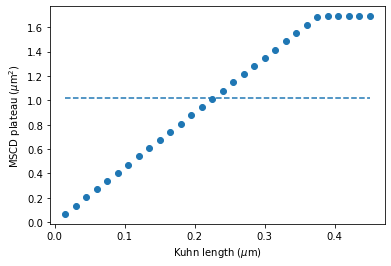

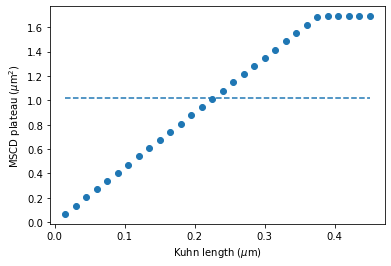

In [3]:
plateau_exp_ura = np.array([1.041056, 1.260354, 1.439587, 1.480568, 1.351417, 1.097409])
plateau_exp_spo = np.array([0.999832, 1.173121, 1.349847, 1.494605, 1.509391, 1.314366, 1.441702])
plateau_exp_0 = np.average([plateau_exp_ura[0],plateau_exp_spo[0]])

plt.figure()

plt.scatter(kuhn_length_vec, mscd_biased)
plt.plot(kuhn_length_vec, 0 * kuhn_length_vec + plateau_exp_0,'--')

plt.xlabel('Kuhn length ($\mu$m)')
plt.ylabel('MSCD plateau ($\mu$m$^2$)') 

plt.show()

kuhn_length = np.interp(plateau_exp_0, mscd_biased, kuhn_length_vec)

Determine the nuclear radius using the long-time values of the MSCD plateau

In [4]:
plateau_exp_longtime = np.average([1.494605, 1.509391, 1.441702])

In [5]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_radius_0 = 1
nuc_radius_f = 2.5
n_nuc = 50
nuc_radius_vec = np.linspace(nuc_radius_0, nuc_radius_f, n_nuc)

r2_theory = np.zeros(n_nuc)
for i_nuc in range(n_nuc):
    nuc_radius = nuc_radius_vec[i_nuc]
    r2_theory[i_nuc] = 2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500)

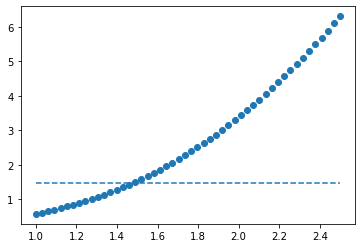

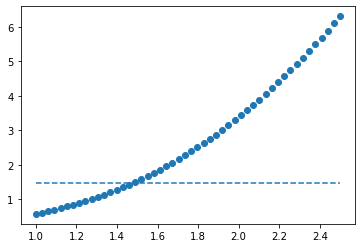

In [6]:
plt.figure()
plt.scatter(nuc_radius_vec, r2_theory)
plt.plot(nuc_radius_vec, 0*nuc_radius_vec + plateau_exp_longtime,'--')

nuc_radius = np.interp(plateau_exp_longtime, r2_theory, nuc_radius_vec)

Determine the fraction of cells in Rabl configuration based on the fitted Kuhn length and linker length. Evaluate the rate constant of centromere detachment

In [7]:
frac_rabl = np.minimum((plateau_exp_spo - plateau_exp_longtime) / (plateau_exp_0 - plateau_exp_longtime), np.ones(7))

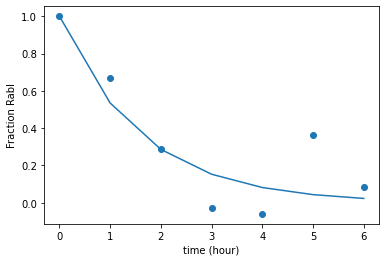

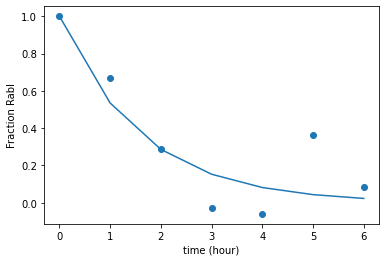

In [8]:
time_exp = np.linspace(0,6,7)
p_rabl = np.polyfit(time_exp[0:3], np.log(frac_rabl[0:3]),1)
k_rabl = -p_rabl[0]

plt.scatter(time_exp, frac_rabl)
plt.plot(time_exp, np.exp(-k_rabl * time_exp),'-')

plt.xlabel('time (hour)')
plt.ylabel('Fraction Rabl') 

plt.savefig('meiosis-figures-final/frac_rabl.pdf', bbox_inches='tight')
plt.show()

Evaluate the MSCD and biased MSCD at the fitted kuhn length and linker length

In [9]:
linker_length = 15

chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])

mus = np.linspace(0, 20, 101)
n_cells = 100000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))

mscd_fit = np.zeros_like(mus)
mscd_fit_biased = np.zeros_like(mus)
mscd_rabl_fit = np.zeros_like(mus)
mscd_rabl_fit_biased = np.zeros_like(mus)
for i, mu in enumerate(mus):
    n_cells_biased = 0
    n_cells_rabl_biased = 0    
    for j in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        mscd_fit[i] += (1 / n_cells) * mscd_plateau_cell
        if mscd_plateau_cell > radius_sq_cutoff:
            n_cells_biased += 1
            mscd_fit_biased[i] += mscd_plateau_cell 
            
        cell = np.sort(np.append(cell, cent_loc_um))
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        mscd_rabl_fit[i] += (1 / n_cells) * mscd_plateau_cell
        if mscd_plateau_cell > radius_sq_cutoff:
            n_cells_rabl_biased += 1
            mscd_rabl_fit_biased[i] += mscd_plateau_cell
    mscd_rabl_fit_biased[i] /= n_cells_rabl_biased
    mscd_fit_biased[i] /= n_cells_biased


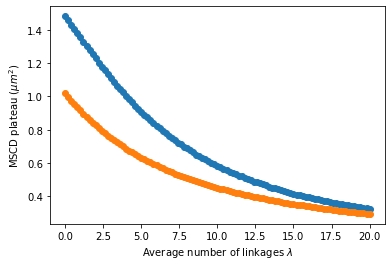

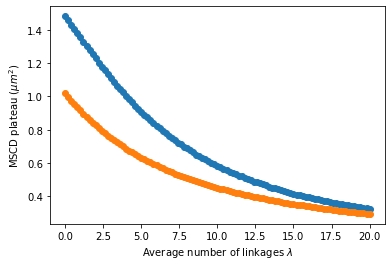

In [10]:
plt.scatter(mus, mscd_fit_biased)
plt.scatter(mus, mscd_rabl_fit_biased)

plt.xlabel('Average number of linkages $\lambda$')
plt.ylabel('MSCD plateau ($\mu{}m^2$)') 

plt.show()

Evaluate the average number of linkages by fitting the ura3 data

In [11]:
time_exp = np.linspace(0,6,7)
mu_fit_ura = np.zeros(7)
mscd_fit_ura = np.zeros(7)
mscd_fit_spo = np.zeros(7)
for i_exp in range(len(plateau_exp_ura)):
    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mscd_combo_fit_biased = frac_rabl * mscd_rabl_fit_biased + (1 - frac_rabl) * mscd_fit_biased
    mu_fit_ura[i_exp] = np.interp(plateau_exp_ura[i_exp], np.flipud(mscd_combo_fit_biased), np.flipud(mus))
    
    mscd_fit_ura[i_exp] = np.interp(mu_fit_ura[i_exp], mus, mscd_combo_fit_biased)
    mscd_fit_spo[i_exp] = mscd_combo_fit_biased[0]

i_exp = 6
frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
mscd_combo_fit_biased = frac_rabl * mscd_rabl_fit_biased + (1 - frac_rabl) * mscd_fit_biased
mscd_fit_spo[i_exp] = mscd_combo_fit_biased[0]

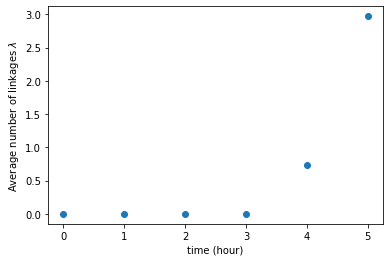

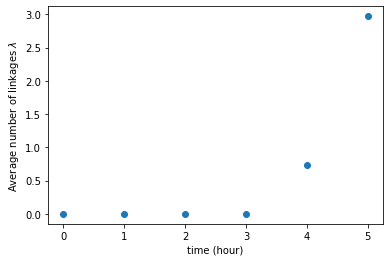

array([0.        , 0.        , 0.        , 0.        , 0.74009112,
       2.97015044, 0.        ])

array([0.        , 0.        , 0.        , 0.        , 0.74009112,
       2.97015044, 0.        ])

In [12]:
plt.scatter(time_exp[0:6], mu_fit_ura[0:6])

plt.ylabel('Average number of linkages $\lambda$')
plt.xlabel('time (hour)')

plt.savefig('meiosis-figures-final/ave_link.pdf', bbox_inches='tight')
plt.show()

mu_fit_ura

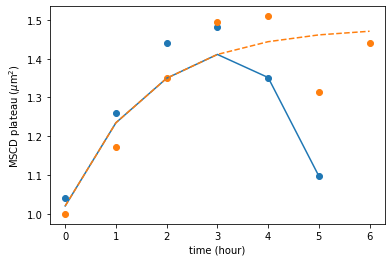

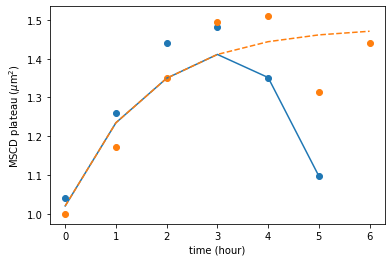

In [13]:
plt.figure()
plt.plot(time_exp[0:6], mscd_fit_ura[0:6],'-')
plt.plot(time_exp, mscd_fit_spo,'--')
plt.scatter(time_exp[0:6], plateau_exp_ura)
plt.scatter(time_exp, plateau_exp_spo)

plt.ylabel('MSCD plateau ($\mu$m$^2$)') 
plt.xlabel('time (hour)')

plt.savefig('meiosis-figures-final/mscd_fit.pdf', bbox_inches='tight')
plt.show()

Fit the diffusivity using the URA3 data over time

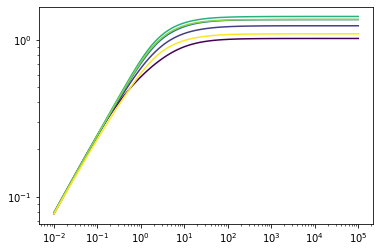

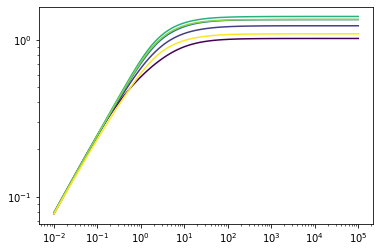

In [36]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
d0 = 1

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))

time_0 = 0.01
time_f = 100000
n_time = 100
time = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = mu_fit_ura[i_exp]
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased
    
    mscd_theory_total = np.append(mscd_theory_total, mscd_theory_exp_d)
    
    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time, mscd_theory_exp_d,'-',c=viridis(color_ratio))

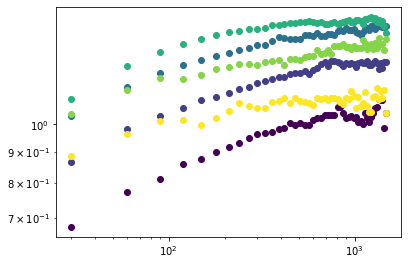

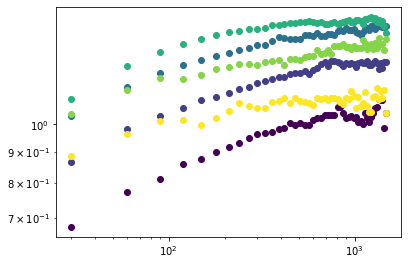

In [48]:
d_scale_0 = 0.105
d_scale_f = 0.11
n_d = 40
d_scale_vec = np.linspace(d_scale_0, d_scale_f, n_d)

fit_ssr = np.zeros(n_d)

msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('URA3', 'WT')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.set_yscale('log')
ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    if i_exp < 6:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))
    
        ind0 = n_time * i_exp
        indf = n_time * i_exp + n_time
    
        for i_d in range(n_d):
            d_scale = d_scale_vec[i_d]
            mscd_fit = np.interp(time_data, time / d_scale, mscd_theory_total[ind0:indf])
            
            fit_ssr[i_d] += np.sum((np.log10(mscd_fit / mscd_data)) ** 2)
    
    i_exp += 1


0.10811327333418817

0.10811327333418817

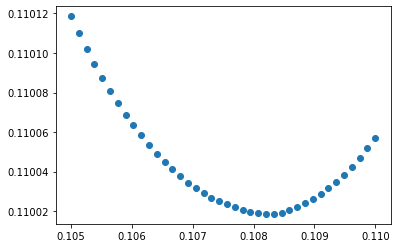

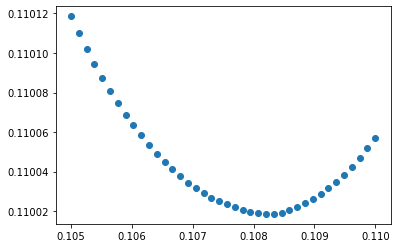

In [49]:
plt.figure()
plt.scatter(d_scale_vec, fit_ssr)

p_ssr = np.polyfit(d_scale_vec, fit_ssr, 2)
d_scale_min = - p_ssr[1] / (2 * p_ssr[0]) 
d_scale_min

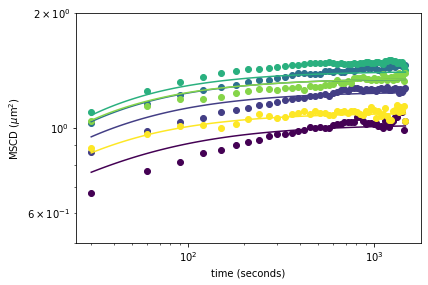

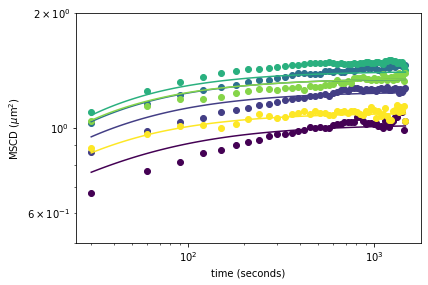

In [50]:
msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('URA3', 'WT')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.set_yscale('log')
ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    if i_exp < 6:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))    
    i_exp += 1
        

chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
d0 = d_scale_min

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        
        
time_0 = 30
time_f = 1470
n_time = 100
time = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = mu_fit_ura[i_exp]
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased

    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time, mscd_theory_exp_d,'-',c=viridis(color_ratio))
    
    
csfont = {'fontname':'Times New Roman'}

ax.set_ylim([0.5, 2])
#    ax.set_ylim([10 ** -1, 10 ** 1])    
#    ax.set_ylim([10 ** -1, 2])    
#ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2])
#ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", r"$2\times10^{0}$"],**csfont)
        
plt.ylabel('MSCD ($\mu$m$^2$)')
plt.xlabel('time (seconds)')

plt.savefig('meiosis-figures-final/mscd_dyn_ura3.pdf', bbox_inches='tight')
plt.show()

In [ ]:
msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('URA3', 'SP')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.set_yscale('log')
ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (len(plateau_exp_spo)-1)
    if i_exp < 7:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))    
    i_exp += 1
        

chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
d0 = d_scale_min

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        
        
time_0 = 30
time_f = 1470
n_time = 100
time = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = 0
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased

    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time, mscd_theory_exp_d,'-',c=viridis(color_ratio))
    
    
csfont = {'fontname':'Times New Roman'}

ax.set_ylim([0.5, 2])
#    ax.set_ylim([10 ** -1, 10 ** 1])    
#    ax.set_ylim([10 ** -1, 2])    
#ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2])
#ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", r"$2\times10^{0}$"],**csfont)
        
plt.ylabel('MSCD ($\mu$m$^2$)')
plt.xlabel('time (seconds)')

plt.savefig('meiosis-figures-final/mscd_dyn_spo.pdf', bbox_inches='tight')
plt.show()

In [ ]:
msds_file = Path('meiosis-figures/msds_dvel_unp.csv')
strain=('LYS2', 'WT')
if not msds_file.exists():
    burgess.msds.precompute_msds()
mscds = pd.read_csv(msds_file) \
    .set_index(['locus', 'genotype', 'meiosis'])

d = mscds.loc[strain]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

ax.set_yscale('log')
ax.set_xscale('log')

## draw all the MSCDs
thick_lines = [0, 3, 6] if strain == ('URA3', 'SP') else [0, 3, 5]
lines = {}
i_exp = 0
for meiosis, data in d.groupby('meiosis'):
    t = -1 if meiosis[1] == 'a' else int(meiosis[1])
    data = data[data['delta'] > 0]
    zorder = 1.5 if t < 0 else 2  # 2 is default
    linewidth = 2 if t in thick_lines else 1
    alpha = 0.8 if t < 0 else 1
#    lines[meiosis] = ax.errorbar(data['delta'], data['mean'], data['ste'], 
#                                 zorder=zorder,
#                                 alpha=alpha, lw=linewidth)
    
    time_data = np.zeros(len(data['delta']))
    mscd_data = np.zeros(len(data['mean']))
    for i in range(len(time_data)):
        time_data[i] = data['delta'][i]
        mscd_data[i] = data['mean'][i]        
    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    if i_exp < 6:
        plt.loglog(time_data, mscd_data,'o', c=viridis(color_ratio))    
    i_exp += 1
        

chr_size_bp = 813184
nucleo_length = 146
locus_position_bp = np.mean([469748, 473926])
cent_position_bp = np.mean([238207, 238323])

d0 = d_scale_min

n_cells = 5000
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

nuc_plateau = np.sqrt(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))        
        
time_0 = 30
time_f = 1470
n_time = 100
time = np.logspace(np.log10(time_0),np.log10(time_f),n_time)

mscd_theory_total = np.array([])

for i_exp in range(len(plateau_exp_ura)):
    mscd_theory = np.zeros(len(time))
    mscd_theory_exp_d = np.zeros(len(time))

    frac_rabl = np.exp(-k_rabl * time_exp[i_exp])
    mu = mu_fit_ura[i_exp]
    n_cell_biased = 0
    for i_cell in range(n_cells):
        cell = poly_dyn.generate_example_cell(mu, total_length_um)
        if np.random.uniform() < frac_rabl:
            cell = np.sort(np.append(cell, cent_loc_um))
        d_cell = d0 * np.random.exponential() 
        mscd_plateau_cell = poly_dyn.model_plateau(
            cell, label_loc_um, total_length_um, nuc_plateau, kuhn_length)
        if mscd_plateau_cell > radius_sq_cutoff:
            mscd_theory_exp_d += poly_dyn.model_mscd(
                time, cell, label_loc_um, 
                total_length_um,
                nuc_plateau, kuhn_length, d_cell, num_modes=10000)
            n_cell_biased += 1
    
    mscd_theory_exp_d /= n_cell_biased

    color_ratio = i_exp / (len(plateau_exp_ura)-1)
    plt.loglog(time, mscd_theory_exp_d,'-',c=viridis(color_ratio))
    
    
csfont = {'fontname':'Times New Roman'}

ax.set_ylim([0.5, 2])
#    ax.set_ylim([10 ** -1, 10 ** 1])    
#    ax.set_ylim([10 ** -1, 2])    
#ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2])
#ax.set_yticklabels([r"$5\times{}10^{-1}$", "", "", "", "", "$10^0$", r"$2\times10^{0}$"],**csfont)
        
plt.ylabel('MSCD ($\mu$m$^2$)')
plt.xlabel('time (seconds)')

plt.savefig('meiosis-figures-final/mscd_dyn_lys.pdf', bbox_inches='tight')
plt.show()

Plateau values

In [20]:
chr_size_bp = 576874
nucleo_length = 146
locus_position_bp = np.mean([116167, 116970])
cent_position_bp = np.mean([151987,152104])
linker_length = 15
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

print(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))


1.4815368587554956
1.4815368587554956


In [21]:
chr_size_bp = 813184
nucleo_length = 146
locus_position_bp = np.mean([469748, 473926])
cent_position_bp = np.mean([238207, 238323])

linker_length = 15
radius_sq_cutoff = 0.250 ** 2

chr_size_linker_bp = linker_length * chr_size_bp / (linker_length + nucleo_length)
total_length_kuhn = chr_size_linker_bp * 0.34 * 0.001 / kuhn_length
locus_position_kuhn = total_length_kuhn * locus_position_bp / chr_size_bp
cent_position_kuhn = total_length_kuhn * cent_position_bp / chr_size_bp
label_loc_um = locus_position_kuhn * kuhn_length
cent_loc_um = cent_position_kuhn * kuhn_length
total_length_um = total_length_kuhn * kuhn_length

print(2 * poly_confine.eval_r2_surf(locus_position_kuhn, total_length_kuhn, kuhn_length, 
                                          nuc_radius, n_max=500))



1.2455122951956685
1.2455122951956685
